<a href="https://colab.research.google.com/github/MateoProjects/TFM/blob/main/Training_Dalle_2_in_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Test Dalle implementation using Pytorch

**Source**: https://github.com/lucidrains/dalle2-pytorch

This is a notebook that follows and implements the tutorial that can be found on the Github provided above.



The main purpose of these project is learn and understand how images can be conditioned based on the input text, bias etc... 

\


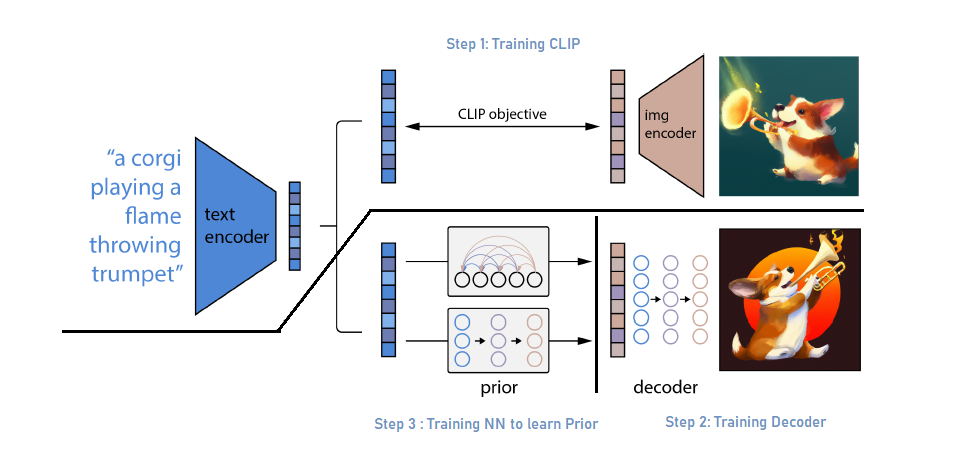

\

**Note:** Step 2 and 3 can be do it in different order. Don't exists any dependence between both steps. 

## Instalation

In [1]:
!pip install -qq dalle2-pytorch

## Step 1: Training CLIP

This clip is an implementation of a recents papers published. This implementation was made it by Lucidrains called x-clip

In [2]:
import torch
from dalle2_pytorch import CLIP

clip = CLIP(
    dim_text = 512,
    dim_image = 512,
    dim_latent = 512,
    num_text_tokens = 49408,
    text_enc_depth = 1,
    text_seq_len = 256,
    text_heads = 8,
    visual_enc_depth = 1,
    visual_image_size = 256,
    visual_patch_size = 32,
    visual_heads = 8,
    use_all_token_embeds = True,            # whether to use fine-grained contrastive learning (FILIP)
    decoupled_contrastive_learning = True,  # use decoupled contrastive learning (DCL) objective function, removing positive pairs from the denominator of the InfoNCE loss (CLOOB + DCL)
    extra_latent_projection = True,         # whether to use separate projections for text-to-image vs image-to-text comparisons (CLOOB)
    use_visual_ssl = True,                  # whether to do self supervised learning on images
    visual_ssl_type = 'simclr',             # can be either 'simclr' or 'simsiam', depending on using DeCLIP or SLIP
    use_mlm = False,                        # use masked language learning (MLM) on text (DeCLIP)
    text_ssl_loss_weight = 0.05,            # weight for text MLM loss
    image_ssl_loss_weight = 0.05            # weight for image self-supervised learning loss
).cuda()

# mock data

text = torch.randint(0, 49408, (4, 256)).cuda()
images = torch.randn(4, 3, 256, 256).cuda()

# train

loss = clip(
    text,
    images,
    return_loss = True              # needs to be set to True to return contrastive loss
)

loss.backward()



In [3]:
import sys
print("Size of clip:", sys.getsizeof(clip)/1048576, "mb")
print("Size of images:", sys.getsizeof(images)/1048576, "mb")
print("Size of text", sys.getsizeof(text)/1048576, "mb")
mem = torch.cuda.mem_get_info()
print("Free memory:", mem[0]/1048576, "mb")
print("Total memory", mem[1]/1048576, "mb")

Size of clip: 6.103515625e-05 mb
Size of images: 8.392333984375e-05 mb
Size of text 8.392333984375e-05 mb
Free memory: 13559.75 mb
Total memory 15109.75 mb


## Step 2: Training a decoder

In [4]:
# unet for the decoder
from dalle2_pytorch import Unet, Decoder

unet = Unet(
    dim = 64,
    image_embed_dim = 512,
    cond_dim = 128,
    channels = 3,
    dim_mults=(1, 2, 4, 8)
).cuda()
# decoder, which contains the unet and clip

decoder = Decoder(
    unet = unet,
    clip = clip,
    timesteps = 100,
    image_cond_drop_prob = 0.1,
    text_cond_drop_prob = 0.5
).cuda()

# mock images (get a lot of this)
images = torch.randn(4, 3, 256, 256).cuda()
print(sys.getsizeof(decoder))
# feed images into decoder

loss = decoder(images)
loss.backward()

64


In [5]:
print("Size of decoder:", sys.getsizeof(decoder))
print("Size of images:", sys.getsizeof(images))
print("Size of text", sys.getsizeof(text))
mem = torch.cuda.mem_get_info()
print("Free memory:", mem[0]/1048576, "mb")
print("Total memory", mem[1]/1048576, "mb")


Size of decoder: 64
Size of images: 88
Size of text 88
Free memory: 1789.75 mb
Total memory 15109.75 mb


## Step 3: Train the Prior Network

In [6]:
from dalle2_pytorch import DiffusionPriorNetwork, DiffusionPrior, DiffusionPriorTrainer

prior_network = DiffusionPriorNetwork(
    dim = 512,
    depth = 6,
    dim_head = 64,
    heads = 8
).cuda()

# diffusion prior network, which contains the CLIP and network (with transformer) above

diffusion_prior = DiffusionPrior(
    net = prior_network,
    clip = clip,
    timesteps = 100,
    cond_drop_prob = 0.2
).cuda()

# mock data

text = torch.randint(0, 49408, (4, 256)).cuda()
images = torch.randn(4, 3, 256, 256).cuda()

# feed text and images into diffusion prior network

diffusion_prior_trainer = DiffusionPriorTrainer(
    diffusion_prior,
    lr = 3e-4,
    wd = 1e-2,
    ema_beta = 0.99,
    ema_update_after_step = 1000,
    ema_update_every = 10,
)

loss = diffusion_prior_trainer(text, images, max_batch_size = 4)
diffusion_prior_trainer.update()  # this will update the optimizer as well as the exponential moving averaged diffusion prior


In [7]:
print("Size of diffusion prior trainer:", sys.getsizeof(diffusion_prior_trainer)/1048576, "mb")
print("Size of images:", sys.getsizeof(images)/1048576, "mb")
print("Size of text", sys.getsizeof(text)/1048576, "mb")
mem = torch.cuda.mem_get_info()
print("Free memory:", mem[0]/1048576, "mb")
print("Total memory", mem[1]/1048576, "mb")

Size of diffusion prior trainer: 6.103515625e-05 mb
Size of images: 8.392333984375e-05 mb
Size of text 8.392333984375e-05 mb
Free memory: 1687.75 mb
Total memory 15109.75 mb


## Generating images from text

In [22]:
from dalle2_pytorch import DALLE2

dalle2 = DALLE2(
    prior = diffusion_prior,
    decoder = decoder
)

# send the text as a string if you want to use the simple tokenizer from DALLE v1
# or you can do it as token ids, if you have your own tokenizer

texts = ['glistening morning dew on a flower petal']
images = dalle2(texts) # (1, 3, 256, 256)
images = images.data.cpu().numpy()


sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

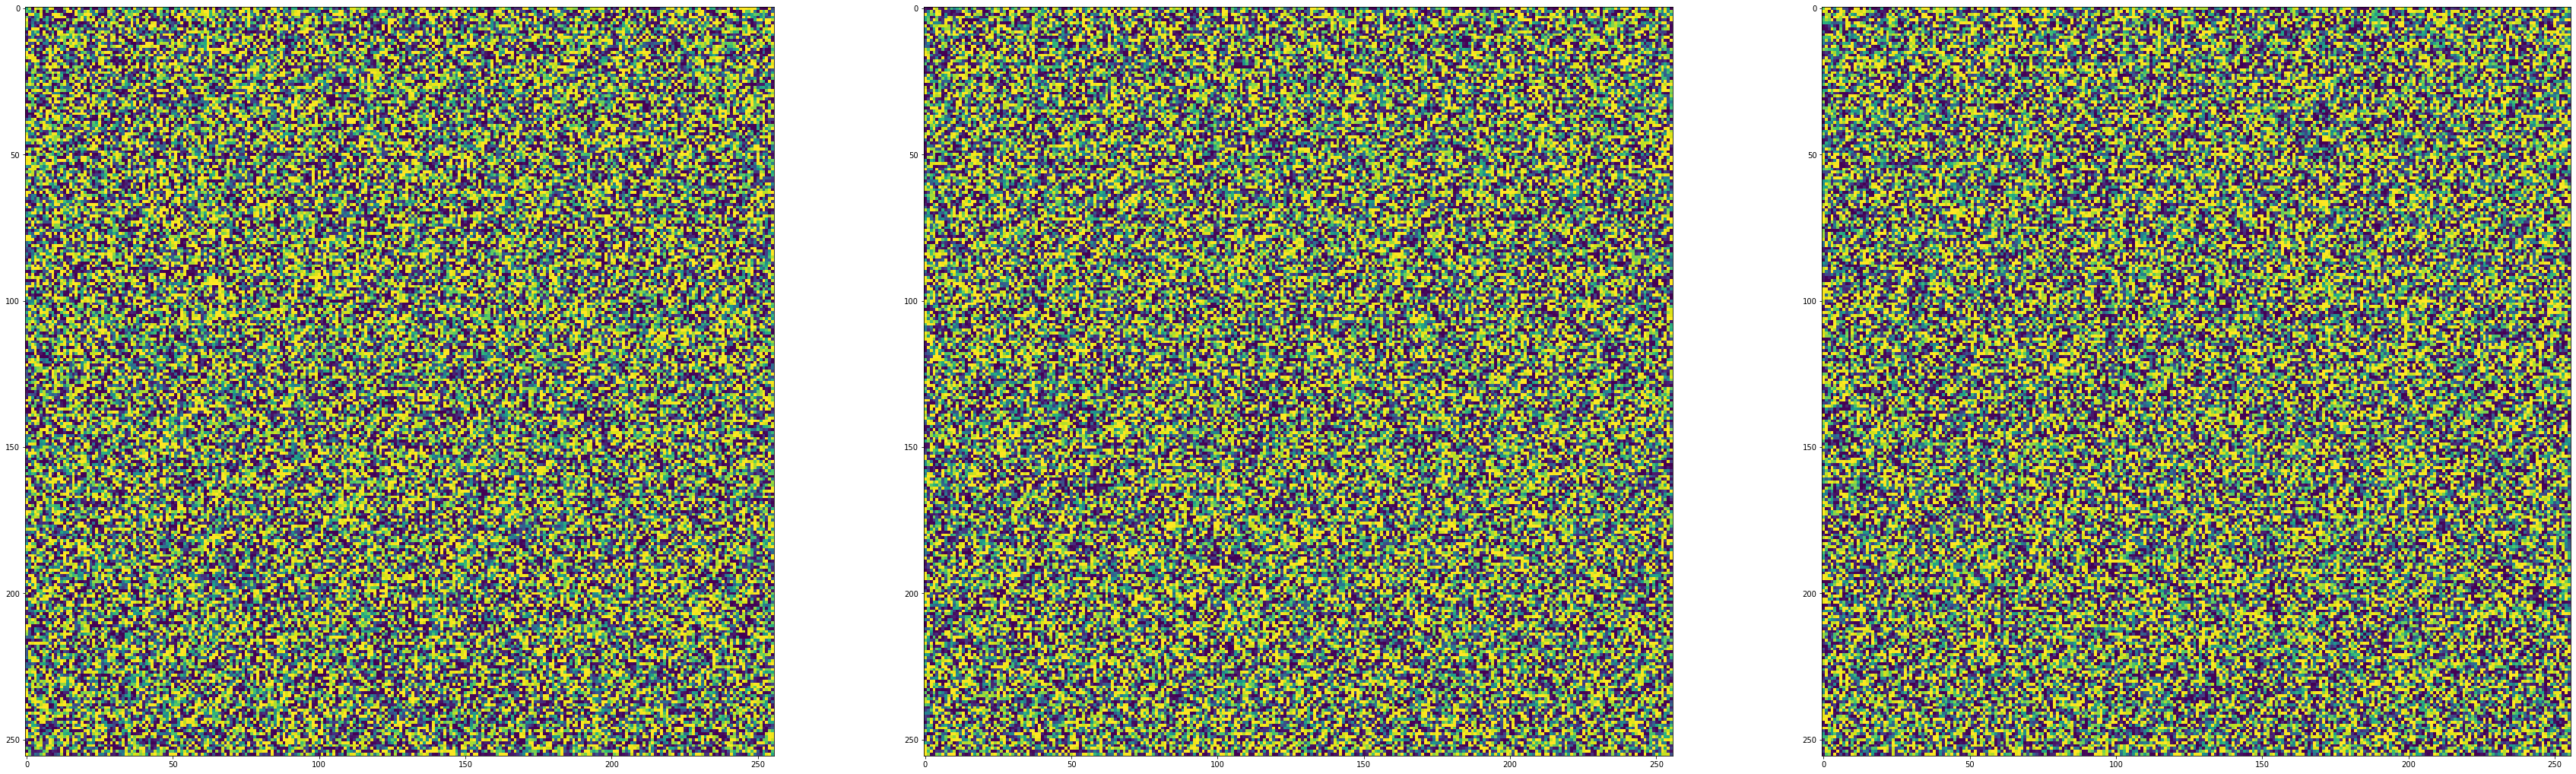

In [30]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 3, figsize=(60,60))
for i in range(3):
  axs[i].imshow(images[0,i])

(1, 3, 256, 256)